In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels
import statsmodels.api as sm
from itertools import combinations
from ydata_profiling import ProfileReport
import tqdm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Initial Exploration

In [5]:
def read_file(file, path = os.path.join(sys.path[0],'assessment', 'data'), extra = ''):
    path = path + '/' + extra
    df = pd.read_csv(path + file)
    return df

### Donor Information.csv

In [6]:
df = read_file('donor_information.csv')
df.head()

donor_id        name    age sex apo_e4_allele  education_years  \
0  326765665  H14.09.078     87   M             N               16   
1  326765656  H14.09.069  95-99   M             N               17   
2  326765654  H14.09.067     85   M             Y               10   
3  467056391  H15.09.103  90-94   F             N               11   
4  309335447  H14.09.010   100+   M             Y               16   

   age_at_first_tbi longest_loc_duration  cerad  num_tbi_w_loc  \
0                 0       Unknown or N/A      0              0   
1                12              1-2 min      2              1   
2                72             < 10 sec      3              1   
3                87             < 10 sec      0              1   
4                 0       Unknown or N/A      3              0   

  dsm_iv_clinical_diagnosis  control_set         nincds_arda_diagnosis  \
0               No Dementia           31                   No Dementia   
1               No Dementia           26                   No Dementia   
2                  Vascular           25        Dementia, Type Unknown   
3               No Dementia           52                   No Dementia   
4  Alzheimer's Disease Type           28  Possible Alzheimer'S Disease   

  ever_tbi_w_loc   race      hispanic act_demented  braak  nia_reagan  
0              N  White  Not Hispanic  No Dementia      1           1  
1              Y  White  Not Hispanic  No Dementia      5           2  
2              Y  White  Not Hispanic     Dementia      4           2  
3              Y  White  Not Hispanic  No Dementia      4           0  
4              N  White  Not Hispanic     Dementia      4           2

In [7]:
df['nincds_arda_diagnosis'].value_counts()

No Dementia                     56
Probable Alzheimer'S Disease    22
Possible Alzheimer'S Disease    21
Dementia, Type Unknown           8
Name: nincds_arda_diagnosis, dtype: int64

In [8]:
df['nincds_arda_diagnosis'] = df['nincds_arda_diagnosis'].replace("Possible Alzheimer'S Disease",
                                                                  "Probable Alzheimer'S Disease")
df = df[df['nincds_arda_diagnosis'] != 'Dementia, Type Unknown']
df['nincds_arda_diagnosis'].value_counts()

No Dementia                     56
Probable Alzheimer'S Disease    43
Name: nincds_arda_diagnosis, dtype: int64

In [9]:
df.groupby(['nincds_arda_diagnosis', 'age']).size()

nincds_arda_diagnosis         age  
No Dementia                   100+      1
                              78        8
                              79        1
                              81        3
                              82        1
                              84        2
                              85        1
                              86        4
                              87        4
                              88        2
                              89        4
                              90-94    13
                              95-99    12
Probable Alzheimer'S Disease  100+      6
                              78        1
                              79        1
                              82        2
                              83        1
                              84        1
                              85        2
                              86        2
                              87        2
                              88        

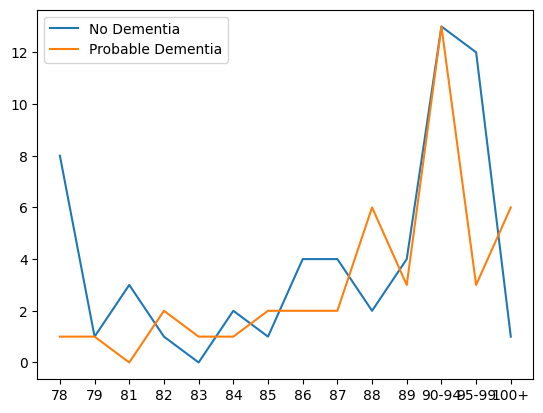

In [10]:
index = df['age'].unique()
index = sorted(index)
index = index[1:]
index.append('100+')
index

dict1 = df.groupby(['nincds_arda_diagnosis', 'age']).size()['No Dementia'].to_dict()
dict2 = df.groupby(['nincds_arda_diagnosis', 'age']).size()["Probable Alzheimer'S Disease"].to_dict()
val1 = [dict1[i] if i in dict1.keys() else 0 for i in index ]
val2 = [dict2[i] if i in dict2.keys() else 0 for i in index ]

plt.plot(index, val1, label = 'No Dementia')
plt.plot(index, val2, label = 'Probable Dementia')
plt.legend()
plt.show()

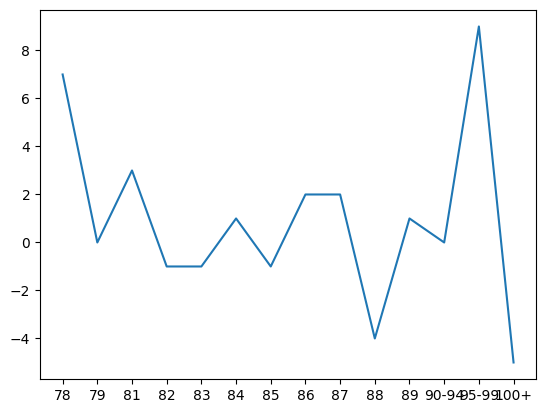

In [11]:
val3 = [i-j for i, j in zip(val1, val2)]
plt.plot(index, val3)

In [12]:
df.groupby(['nincds_arda_diagnosis', 'apo_e4_allele']).size()

nincds_arda_diagnosis         apo_e4_allele
No Dementia                   N                47
                              Y                 7
Probable Alzheimer'S Disease  N                27
                              Y                12
dtype: int64

###### Variable Inspection

In [13]:
profile = ProfileReport(df, title = 'Profiling Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Protein And Pathology Quantifications.csv

In [14]:
df1 = read_file('protein_and_pathology_quantifications.csv')
df1.head()

donor_id  donor_name  structure_id structure_acronym  ihc_a_syn  \
0  309335467  H14.09.030         10557               FWM   0.000078   
1  309335480  H14.09.043         10208               PCx   0.000063   
2  309335493  H14.09.056         10557               FWM   0.000064   
3  326765668  H14.09.081         10557               FWM   0.000049   
4  326765668  H14.09.081         10235               TCx   0.000080   

   ihc_tau2_ffpe  ihc_at8_ffpe   ihc_at8  ihc_ptdp_43_ffpe  ihc_a_beta_ffpe  \
0       0.002358      0.001137  0.000110          0.001259         0.008335   
1       0.002762      0.001272  0.000164          0.002354         0.005047   
2       0.003468      0.013787  0.016023          0.001708         0.007365   
3       0.003035      0.001707  0.000137          0.001729         0.004046   
4       0.002088      0.004489  0.000062          0.001513         0.015809   

   ...  il_4_pg_per_mg  rantes_pg_per_mg  ab40_pg_per_mg  a_syn_pg_per_mg  \
0  ...            2.68             15.99        0.736100         0.122288   
1  ...            3.02             24.04        0.669094         0.111962   
2  ...            0.80            129.80        0.736100         0.091084   
3  ...            1.30             15.16        8.995575         0.054076   
4  ...            0.00             17.90       95.931000         0.030000   

   ifn_g_pg_per_mg  mcp_1_pg_per_mg  bdnf_pg_per_mg  mip_1a_pg_per_mg  \
0             1.47            20.78         5.03736              9.38   
1             1.44            40.40         4.95462              8.10   
2             0.54            46.88         5.88409             27.00   
3             0.76            10.34        16.13524              8.06   
4             1.22            21.38         0.03000             10.52   

   il_7_pg_per_mg  ab42_pg_per_mg  
0           11.78      523.292251  
1           45.02       81.493875  
2           15.82      470.734514  
3           24.22      568.368571  
4           23.72      438.863263  

[5 rows x 33 columns]

In [15]:
len(df1)

377

In [16]:
len(df1.columns)

33

In [17]:
df1['structure_acronym'].value_counts()

TCx    99
HIP    94
FWM    93
PCx    91
Name: structure_acronym, dtype: int64

In [18]:
df1[df1['donor_name'] == 'H14.09.001']

donor_id  donor_name  structure_id structure_acronym  ihc_a_syn  \
24   309335438  H14.09.001         10235               TCx   0.000138   
260  309335438  H14.09.001         10557               FWM   0.000104   
282  309335438  H14.09.001         10208               PCx   0.000103   
346  309335438  H14.09.001         10294               HIP   0.001042   

     ihc_tau2_ffpe  ihc_at8_ffpe   ihc_at8  ihc_ptdp_43_ffpe  ihc_a_beta_ffpe  \
24        0.001742      0.007628  0.000090          0.001917         0.007665   
260       0.002030      0.000677  0.000060          0.001351         0.003513   
282       0.002360      0.000789  0.000095          0.001703         0.004528   
346       0.008601      0.023308  0.022335          0.002349         0.006869   

     ...  il_4_pg_per_mg  rantes_pg_per_mg  ab40_pg_per_mg  a_syn_pg_per_mg  \
24   ...            0.86             62.82        0.000000         0.020000   
260  ...            0.02             43.98        0.322081         0.070502   
282  ...            0.00             56.28        0.621950         0.046742   
346  ...            0.00             22.04        0.746850         0.411676   

     ifn_g_pg_per_mg  mcp_1_pg_per_mg  bdnf_pg_per_mg  mip_1a_pg_per_mg  \
24              0.44            27.68         0.02000             12.34   
260             0.00            34.22         2.92748             10.42   
282             0.02            24.54         2.60468             10.26   
346             1.06             1.36         4.19939             51.08   

     il_7_pg_per_mg  ab42_pg_per_mg  
24            24.74        0.078225  
260           10.54        0.225300  
282            7.82       31.100787  
346            0.16        0.235788  

[4 rows x 33 columns]

In [19]:
df2 = df1.pivot_table(index = ['donor_id', 'donor_name'],
                      columns = ['structure_acronym'],
                      values = df1.columns[4:].tolist(),
                      aggfunc = 'sum').reset_index()
df2.columns = ['_'.join(col) if col[0] != 'donor_id' or col[0] != 'donor_name' else col for col in df2.columns]
df2 = df2.rename({'donor_id_': 'donor_id',
                  'donor_name_': 'donor_name'}, axis = 1)

In [20]:
df2

donor_id  donor_name  a_syn_pg_per_mg_FWM  a_syn_pg_per_mg_HIP  \
0    309335438  H14.09.001             0.070502             0.411676   
1    309335439  H14.09.002             0.050262             0.060818   
2    309335440  H14.09.003                  NaN             0.000000   
3    309335441  H14.09.004             0.066102             0.191904   
4    309335442  H14.09.005                  NaN             0.278622   
..         ...         ...                  ...                  ...   
102  467056405  H15.09.106                  NaN             0.000000   
103  467056406  H15.09.107             0.047522             0.117469   
104  467056407  H15.09.108             0.025050             0.037711   
105  467056408  H15.09.109             0.042141             0.147220   
106  467056409  H15.09.110             0.096579             0.316231   

     a_syn_pg_per_mg_PCx  a_syn_pg_per_mg_TCx  ab40_pg_per_mg_FWM  \
0               0.046742             0.020000            0.322081   
1               0.047842             0.030000            0.366506   
2                    NaN             0.020000                 NaN   
3               0.094482             0.170000            0.444250   
4                    NaN                  NaN                 NaN   
..                   ...                  ...                 ...   
102                  NaN             0.000000                 NaN   
103             0.044990             0.000000            1.737356   
104             0.041825             0.028216            0.655069   
105             0.070626             0.065562            0.303800   
106             0.227610             0.191529            0.151900   

     ab40_pg_per_mg_HIP  ab40_pg_per_mg_PCx  ab40_pg_per_mg_TCx  ...  \
0              0.746850            0.621950            0.000000  ...   
1              0.698975            0.333188            0.946400  ...   
2              0.000000                 NaN            0.000000  ...   
3              0.964013            1.632619            1.474200  ...   
4              2.249363                 NaN                 NaN  ...   
..                  ...                 ...                 ...  ...   
102            0.000000                 NaN            0.000000  ...   
103           61.528994           18.816613            0.000000  ...   
104            1.661406            1.974700            1.471531  ...   
105            0.151900            0.778487            0.721525  ...   
106            0.512663            0.731019            1.348113  ...   

     tau_ng_per_mg_PCx  tau_ng_per_mg_TCx  tnf_a_pg_per_mg_FWM  \
0             1.160677           0.000000                 0.00   
1             1.177012           1.369168                 0.00   
2                  NaN           0.000000                  NaN   
3             1.190050           1.481616                 0.00   
4                  NaN                NaN                  NaN   
..                 ...                ...                  ...   
102                NaN           0.000000                  NaN   
103           1.088445           0.000000                 0.00   
104           1.652758           1.607476                 1.62   
105           1.515285           1.686060                 0.67   
106           1.548735           1.602570                 0.00   

     tnf_a_pg_per_mg_HIP  tnf_a_pg_per_mg_PCx  tnf_a_pg_per_mg_TCx  \
0                  13.02                 1.02                 0.00   
1                  18.00                 0.00                 0.00   
2                   0.00                  NaN                 0.00   
3                  27.92                 0.00                 3.28   
4                  12.48                  NaN                  NaN   
..                   ...                  ...                  ...   
102                15.09                  NaN                 0.00   
103                25.30                 0.00                 0.00   
104                13.58

### Group Weights.csv

In [21]:
df3 = read_file('group_weights.csv')
df3.head()

Donor ID  Weight
0  H14.09.001    7.84
1  H14.09.002   20.60
2  H14.09.003    7.84
3  H14.09.004   35.33
4  H14.09.005    8.81

In [22]:
len(df3)

107

###### Variable Inspection

In [23]:
profile = ProfileReport(df3, title = 'Profiling Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### TBI data files

In [24]:
df4 = read_file('tbi_data_files.csv')
df4 = df4.drop(columns = ['gene_level_fpkm_file_link',
                          'anonymized_bam_file_link',
                          'anonymized_bam_index_file_link',
                          'bigwig_file_link'])
df4.head()

donor_id  donor_name  specimen_id      specimen_name   rna_well  \
0  309335438  H14.09.001    309357595  H14.09.001.HIP.05  320630832   
1  309335438  H14.09.001    309357596  H14.09.001.PCx.01  320630834   
2  309335438  H14.09.001    309357596  H14.09.001.PCx.01  320630836   
3  309335438  H14.09.001    309357599  H14.09.001.TCx.01  320630838   
4  309335439  H14.09.002    309357603  H14.09.002.HIP.01  320630842   

   rna_integrity_number  structure_id structure_acronym  \
0                   7.3         10294               HIP   
1                   7.2         10557               FWM   
2                   7.1         10208               PCx   
3                   7.3         10235               TCx   
4                   6.4         10294               HIP   

                        structure_name  rnaseq_profile_id  rnaseq_total_reads  \
0  hippocampus (hippocampal formation)          496100314            32275545   
1            white matter of forebrain          496100278            32515376   
2                   parietal neocortex          496100290            34426215   
3                   temporal neocortex          496100279            31714711   
4  hippocampus (hippocampal formation)          496100281            33402591   

   rnaseq_percent_reads_aligned_to_mrna  \
0                                  31.7   
1                                  29.0   
2                                  29.1   
3                                  31.4   
4                                  29.5   

   rnaseq_percent_reads_aligned_to_ncrna  \
0                                   7.11   
1                                   8.21   
2                                   6.59   
3                                   6.97   
4                                   7.21   

   rnaseq_percent_reads_aligned_to_genome_only  
0                                         48.1  
1                                         49.5  
2                                         52.1  
3                                         48.7  
4                                         50.6

In [25]:
len(df4)

377

### Rows Genes.csv

In [26]:
df6 = read_file('rows_genes.csv', extra = 'gene_expression_matrix_2016-03-03/')
df6.head()

gene_id chromosome  gene_entrez_id gene_symbol  \
0  499304660          1       100287102     DDX11L1   
1  499304661          1          653635      WASH7P   
2  499304662          1       102466751   MIR6859-1   
3  499304663          1       100302278   MIR1302-2   
4  499304664          1          645520     FAM138A   

                                           gene_name  
0  DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 l...  
1            WAS protein family homolog 7 pseudogene  
2                                    microRNA 6859-1  
3                                    microRNA 1302-2  
4      family with sequence similarity 138, member A

In [27]:
len(df6)

50281

### fpkm_table_normalized.csv

In [28]:
df7 = read_file('fpkm_table_normalized.csv', extra = 'gene_expression_matrix_2016-03-03/')
df7.head()

gene_id \ rnaseq_profile_id  488395315  496100277  496100278  496100279  \
0                    499304660   0.655725   0.095143   0.000000   0.000000   
1                    499304661   4.526404   8.855850   4.868456   4.851842   
2                    499304662   0.000000   0.000000   0.000000   0.000000   
3                    499304663   0.000000   0.000000   0.000000   0.000000   
4                    499304664   0.039654   0.016492   0.000000   0.170431   

   496100281  496100283  496100284  496100285  496100287  ...  496100661  \
0   0.000000   0.000000   0.000000   0.151241   0.172735  ...   0.280921   
1   3.600344   5.130615   5.496470   4.830538   4.565007  ...   5.996864   
2   0.000000   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
3   0.000000   0.000000   0.000000   0.000000   0.000000  ...   0.000000   
4   0.000000   0.007901   0.137523   0.087973   0.000000  ...   0.000000   

   496100663  496100664  496100665  496100666  496100667  496100669  \
0   0.464819   0.000000   0.316875   0.250307   0.000000   0.000000   
1   3.933522   4.831699   4.727912   4.645094   5.664388   8.329654   
2   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4   0.073427   0.040766   0.044743   0.119941   0.114818   0.143532   

   496100670  496100671  496100672  
0   0.126133   0.000000    0.00000  
1   5.712798   4.639818    4.70802  
2   0.000000   0.000000    0.00000  
3   0.000000   0.000000    0.00000  
4   0.000000   0.075834    0.00000  

[5 rows x 378 columns]

In [29]:
len(df7.columns)

378

In [30]:
len(df7)

50281

## Merge and Convert factors

In [31]:
def initialize():
  merge = df.merge(df2, on = 'donor_id')
  temp = df3.rename({'Donor ID': 'name'}, axis = 1)
  merge = merge.merge(temp, on = 'name')
  return merge

In [32]:
merge = initialize()

In [33]:
len(merge.columns)

137

In [34]:
def mappings(merge):
  index = ['78', '79', '81', '82', '83', '84', '85', '86', '87',
           '88', '89', '90-94', '95-99', '100+']
  mapping = {}
  for i,j in zip(index, range(1, len(index) + 1)):
    mapping[i] = j
  merge['age'] = merge['age'].map(mapping)
  merge['sex'] = merge['sex'].map({'M': 1, 'F': 0})
  merge['ever_tbi_w_loc'] = merge['ever_tbi_w_loc'].map({'Y': 1, 'N': 0})
  merge['act_demented'] = merge['act_demented'].map({'No Dementia': 0, 'Dementia': 1})
  merge['nincds_arda_diagnosis'] = merge['nincds_arda_diagnosis'].map({'No Dementia': 0, "Probable Alzheimer'S Disease": 1})
  merge['apo_e4_allele'] = merge['apo_e4_allele'].map({'Y': 1, 'N': 0})

  return merge

In [35]:
merge = mappings(merge)

## Data Initialize and Augmentation

##### Initial Feature Selection & deal with missings

In [36]:
def missing_imputation(merge, method = 'mean'):

  res = merge.isna().sum()
  res = res[res.values > 0]
  if method == 'drop':
    merge = merge.dropna(subset = ['apo_e4_allele'], axis = 0)
    merge = merge[~merge.isna().any(axis = 1)]
  else:
    merge = merge.dropna(subset = ['apo_e4_allele'], axis = 0)
    merge = merge.fillna(merge.mean())

  return res, merge

In [37]:
merge = initialize()
merge = mappings(merge)

In [38]:
drop = merge.isna().sum()[merge.isna().sum() > 8].index.tolist()

In [39]:
drop

['a_syn_pg_per_mg_FWM',
 'a_syn_pg_per_mg_HIP',
 'a_syn_pg_per_mg_PCx',
 'ab40_pg_per_mg_FWM',
 'ab40_pg_per_mg_HIP',
 'ab40_pg_per_mg_PCx',
 'ab42_over_ab40_ratio_FWM',
 'ab42_over_ab40_ratio_HIP',
 'ab42_over_ab40_ratio_PCx',
 'ab42_pg_per_mg_FWM',
 'ab42_pg_per_mg_HIP',
 'ab42_pg_per_mg_PCx',
 'bdnf_pg_per_mg_FWM',
 'bdnf_pg_per_mg_HIP',
 'bdnf_pg_per_mg_PCx',
 'ifn_g_pg_per_mg_FWM',
 'ifn_g_pg_per_mg_HIP',
 'ifn_g_pg_per_mg_PCx',
 'ihc_a_beta_FWM',
 'ihc_a_beta_HIP',
 'ihc_a_beta_PCx',
 'ihc_a_beta_ffpe_FWM',
 'ihc_a_beta_ffpe_HIP',
 'ihc_a_beta_ffpe_PCx',
 'ihc_a_syn_FWM',
 'ihc_a_syn_HIP',
 'ihc_a_syn_PCx',
 'ihc_at8_FWM',
 'ihc_at8_HIP',
 'ihc_at8_PCx',
 'ihc_at8_ffpe_FWM',
 'ihc_at8_ffpe_HIP',
 'ihc_at8_ffpe_PCx',
 'ihc_gfap_ffpe_FWM',
 'ihc_gfap_ffpe_HIP',
 'ihc_gfap_ffpe_PCx',
 'ihc_iba1_ffpe_FWM',
 'ihc_iba1_ffpe_HIP',
 'ihc_iba1_ffpe_PCx',
 'ihc_ptdp_43_ffpe_FWM',
 'ihc_ptdp_43_ffpe_HIP',
 'ihc_ptdp_43_ffpe_PCx',
 'ihc_tau2_ffpe_FWM',
 'ihc_tau2_ffpe_HIP',
 'ihc_tau2_ffpe_P

Verify if missings are random

In [40]:
drop_ = drop + ['donor_id', 'name', 'nincds_arda_diagnosis', 
            'dsm_iv_clinical_diagnosis', 'donor_name', 'hispanic',
            'longest_loc_duration', 'race',
            'act_demented']

X = merge.copy()
X = X.drop(drop_, axis = 1)

X.isna().sum()

age                          0
sex                          0
apo_e4_allele                6
education_years              0
age_at_first_tbi             0
cerad                        0
num_tbi_w_loc                0
control_set                  0
ever_tbi_w_loc               0
braak                        0
nia_reagan                   0
a_syn_pg_per_mg_TCx          8
ab40_pg_per_mg_TCx           8
ab42_over_ab40_ratio_TCx     8
ab42_pg_per_mg_TCx           8
bdnf_pg_per_mg_TCx           8
ifn_g_pg_per_mg_TCx          8
ihc_a_beta_TCx               8
ihc_a_beta_ffpe_TCx          8
ihc_a_syn_TCx                8
ihc_at8_TCx                  8
ihc_at8_ffpe_TCx             8
ihc_gfap_ffpe_TCx            8
ihc_iba1_ffpe_TCx            8
ihc_ptdp_43_ffpe_TCx         8
ihc_tau2_ffpe_TCx            8
il_10_pg_per_mg_TCx          8
il_1b_pg_per_mg_TCx          8
il_4_pg_per_mg_TCx           8
il_6_pg_per_mg_TCx           8
il_7_pg_per_mg_TCx           8
isoprostane_pg_per_mg_TCx    8
mcp_1_pg

In [41]:
X[X.isna().any(axis = 1)]

age  sex  apo_e4_allele  education_years  age_at_first_tbi  cerad  \
12    3    1            NaN               16                23      1   
17    9    1            0.0                8                26      1   
25   13    0            NaN               11                 0      3   
30    8    0            NaN               12                 0      2   
37    9    0            NaN               14                 0      2   
47   12    1            0.0               12                68      1   
50   14    0            NaN               19                89      2   
61    3    1            0.0               10                 0      0   
71   11    0            0.0               12                 0      1   
78   14    0            0.0               16                89      1   
81   14    0            NaN               17                 0      3   
91    1    1            0.0               21                12      0   
98   12    0            1.0               14                 3      1   

    num_tbi_w_loc  control_set  ever_tbi_w_loc  braak  ...  \
12              2           36               1      1  ...   
17              1           31               1      1  ...   
25              0            8               0      5  ...   
30              0           20               0      4  ...   
37              0            9               0      6  ...   
47              1           24               1      1  ...   
50              1           42               1      5  ...   
61              0           38               0      1  ...   
71              0           43               0      5  ...   
78              1            8               1      4  ...   
81              0           18               0      5  ...   
91              1           41               1      0  ...   
98              2           16               1      5  ...   

    isoprostane_pg_per_mg_TCx  mcp_1_pg_per_mg_TCx  mip_1a_pg_per_mg_TCx  \
12                   5.288949                19.34                  7.82   
17                        NaN                  NaN                   NaN   
25                        NaN                  NaN                   NaN   
30                   0.000000                35.48                  6.44   
37                   0.000000                21.30                 13.38   
47                        NaN                  NaN                   NaN   
50                   1.887212                15.96                  7.90   
61                        NaN                  NaN                   NaN   
71                        NaN                  NaN                   NaN   
78                        NaN                  NaN                   NaN   
81                   0.000000                66.02                 30.56   
91                        NaN                  NaN                   NaN   
98                        NaN                  NaN                   NaN   

    ptau_ng_per_mg_TCx  ptau_over_tau_ratio_TCx  rantes_pg_per_mg_TCx  \
12            1.199505                 0.722669                 14.48   
17                 NaN                      NaN                   NaN   
25                 NaN                      NaN                   NaN   
30            0.522916                 0.351220                 18.76   
37            0.694615                 0.400809                 51.80   
47                 NaN                      NaN                   NaN   
50            1.945282                 1.315970                 46.72   
61                 NaN                      NaN                   NaN   
71                 NaN                      NaN                   NaN   
78                 NaN                      NaN                   NaN   
81            2.637256                 2.194158                337.66   
91                 NaN                      NaN                   NaN   
98                 NaN                      NaN                   NaN   

    tau_ng_per_mg_TCx  t

The missings are not random, imputation is not a good idea in this scenario.

In [42]:
def create_xy(merge, drop):
  drop = drop + ['donor_id', 'name', 
            'dsm_iv_clinical_diagnosis', 'donor_name', 'hispanic',
            'longest_loc_duration', 'race',
            'act_demented']
  
  merge = merge.drop(drop, axis = 1)
  _, merge = missing_imputation(merge, 'drop')

  y = merge['nincds_arda_diagnosis']
  X = merge.drop(['nincds_arda_diagnosis'], axis = 1)

  return X, y

###### Variable check before last Augmentation

In [43]:
merge = initialize()
merge = mappings(merge)
merge = merge.drop(drop, axis = 1)
_, merge = missing_imputation(merge, 'drop')

profile = ProfileReport(merge, title = 'metrics')
profile.to_file('Partial Variable Report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### Second Round Selection

In [44]:
def selection_r2(merge):
  merge['age_at_first_tbi'] = merge['age_at_first_tbi'].apply(lambda x: 1 if x > 0 else 0)
  merge = merge.rename({'age_at_first_tbi': 'ever_tbi'}, axis = 1)
  merge = merge.drop(['Weight', 'control_set',#'num_tbi_w_loc', 'ever_tbi_w_loc', 'braak', 'cerad',
                      'il_1b_pg_per_mg_TCx',
                      'bdnf_pg_per_mg_TCx', ], axis = 1)
  return merge

genereate X, y

In [45]:
merge = initialize()
merge = mappings(merge)
X, y = create_xy(merge, drop)
X = selection_r2(X)

##### All Variables Check and Correlation

In [46]:
profile = merge.copy()
profile = profile.drop(drop + ['donor_id', 'name', 
            'dsm_iv_clinical_diagnosis', 'donor_name', 'hispanic',
            'longest_loc_duration', 'race',
            'act_demented'], axis = 1)
output = ProfileReport(profile, title = 'Dementia Variable Study')
output.to_file('All_Variables.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### transform

In [47]:
def data_transform(merge):
  cols = ['a_syn_pg_per_mg_TCx', 'ab40_pg_per_mg_TCx', 'ab42_over_ab40_ratio_TCx',
       'ab42_pg_per_mg_TCx', 'ifn_g_pg_per_mg_TCx', 'ihc_a_beta_TCx',
       'ihc_a_beta_ffpe_TCx', 'ihc_a_syn_TCx', 'ihc_at8_TCx',
       'ihc_at8_ffpe_TCx', 'ihc_gfap_ffpe_TCx', 'ihc_iba1_ffpe_TCx',
       'ihc_ptdp_43_ffpe_TCx', 'ihc_tau2_ffpe_TCx', 'il_10_pg_per_mg_TCx',
       'il_4_pg_per_mg_TCx', 'il_6_pg_per_mg_TCx', 'il_7_pg_per_mg_TCx',
       'isoprostane_pg_per_mg_TCx', 'mcp_1_pg_per_mg_TCx',
       'mip_1a_pg_per_mg_TCx', 'ptau_ng_per_mg_TCx', 'ptau_over_tau_ratio_TCx',
       'rantes_pg_per_mg_TCx', 'tau_ng_per_mg_TCx', 'tnf_a_pg_per_mg_TCx',
       'vegf_pg_per_mg_TCx']

  for i in cols:
    merge[i] = merge[i].apply(np.cbrt)

  return merge

In [48]:
def prepare_for_tree():
  merge = initialize()
  merge = mappings(merge)
  X, y = create_xy(merge, drop)
  X = selection_r2(X)
  X = X.reset_index(drop = True)
  y = y.reset_index(drop = True)
  return X, y

In [49]:
def prepare_for_glm():
  merge = initialize()
  merge = mappings(merge)
  X, y = create_xy(merge, drop)
  X = selection_r2(X)
  X = data_transform(X)
  X = X.reset_index(drop = True)
  y = y.reset_index(drop = True)
  return X, y

## Model 1 and 2. Initial Explorative Tree Model(non-parametric)

### Model 1. Decision Tree

In [50]:
def single_tree(X, y, cv, max_node = 20):
  '''
  Single Decision Tree Model
  '''
  max_nodes = range(5, max_node + 1)
  train_scores = []
  test_scores = []
  train_variation = []
  test_variation = []

  for i in tqdm(max_nodes):
    train_score = []
    test_score = []
    for j, (train_idx, test_idx) in enumerate(cv.split(X,y)):
      clf = DecisionTreeClassifier(max_leaf_nodes = i, random_state = 315)
      X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
      y_train, y_test = y[train_idx], y[test_idx]
      clf.fit(X_train, y_train)
      train_score.append(roc_auc_score(y_train, clf.predict(X_train)))
      test_score.append(roc_auc_score(y_test, clf.predict(X_test)))
  
    mean_train_score = np.mean(train_score)
    std_train_score = np.std(train_score)
    mean_test_score = np.mean(test_score)
    std_test_score = np.std(test_score)
  
    train_scores.append(mean_train_score)
    test_scores.append(mean_test_score)
    train_variation.append(std_train_score)
    test_variation.append(std_test_score)
  
  return train_scores, test_scores, train_variation, test_variation

In [51]:
def plot_roc(xaxis, train_scores, test_scores, train_variation, test_variation):
  '''
  matplotlib plot roc and variation
  '''
  fig, axs = plt.subplots(1, 2, figsize = (10, 4))
  axs[0].plot(xaxis, train_scores, marker = 'o', label = 'train')
  axs[0].plot(xaxis, test_scores, marker = 'o', label = 'test')
  axs[0].set_title('Cross Val ROC Scores')
  axs[0].set_xticks(xaxis)
  axs[1].plot(xaxis, train_variation, marker = 'o', label = 'train')
  axs[1].plot(xaxis, test_variation, marker = 'o', label = 'test')
  axs[1].set_title('Cross Val ROC Variation')
  axs[1].set_xticks(xaxis)

  fig.tight_layout()
  plt.legend()
  plt.show()

In [52]:
max_nodes = range(5, 21)
X, y = prepare_for_tree()

100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


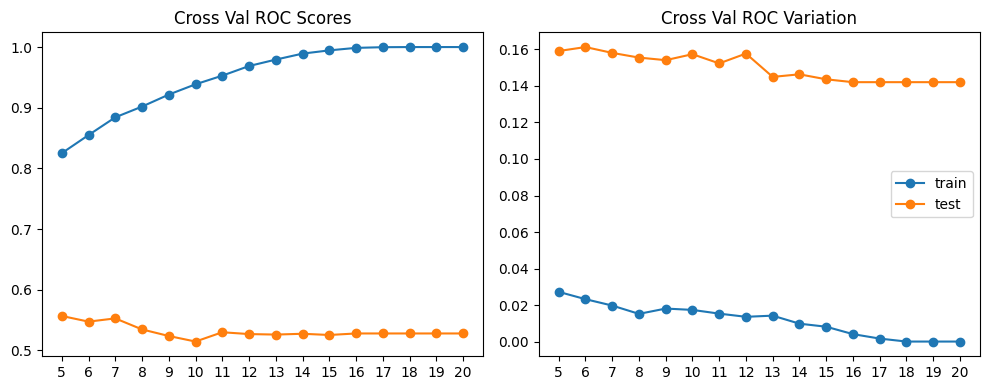

In [53]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315)
model_1_1 = single_tree(X, y, cv)
plot_roc(max_nodes, model_1_1[0], model_1_1[1], model_1_1[2], model_1_1[3])

100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


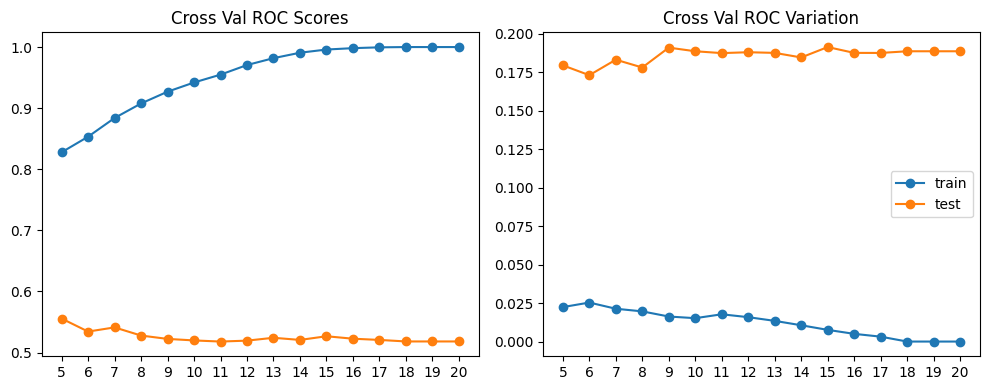

In [54]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77)
model_1_2 = single_tree(X, y, cv)
plot_roc(max_nodes, model_1_2[0], model_1_2[1], model_1_2[2], model_1_2[3])

100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


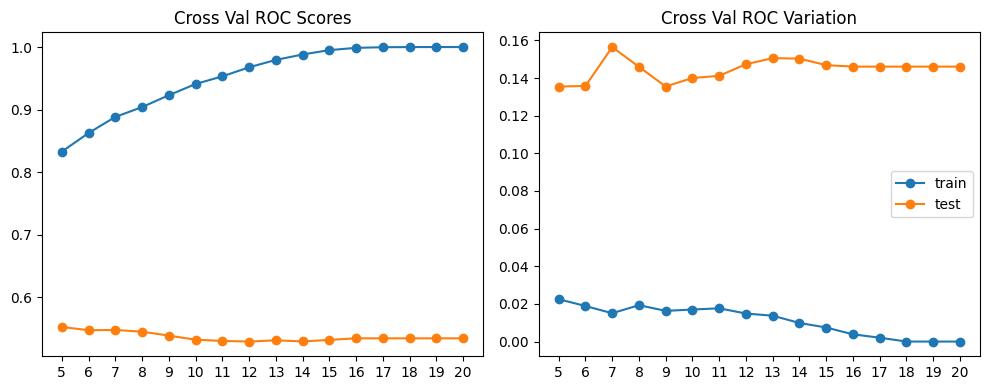

In [55]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 419)
model_1_3 = single_tree(X, y, cv)
plot_roc(max_nodes, model_1_3[0], model_1_3[1], model_1_3[2], model_1_3[3])

In [56]:
def chek_features(X, y, clf, cv):
  '''
  '''
  models = []
  for j, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    models.append(clf)
  return models

[Text(0.5714285714285714, 0.9, 'ihc_at8_ffpe_TCx <= 0.011\ngini = 0.492\nsamples = 78\nvalue = [44, 34]'),
 Text(0.35714285714285715, 0.7, 'cerad <= 0.5\ngini = 0.406\nsamples = 53\nvalue = [38, 15]'),
 Text(0.14285714285714285, 0.5, 'ihc_tau2_ffpe_TCx <= 0.002\ngini = 0.484\nsamples = 17\nvalue = [7, 10]'),
 Text(0.07142857142857142, 0.3, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.21428571428571427, 0.3, 'il_6_pg_per_mg_TCx <= 0.62\ngini = 0.355\nsamples = 13\nvalue = [3, 10]'),
 Text(0.14285714285714285, 0.1, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.2857142857142857, 0.1, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(0.5714285714285714, 0.5, 'ihc_a_syn_TCx <= 0.001\ngini = 0.239\nsamples = 36\nvalue = [31, 5]'),
 Text(0.5, 0.3, 'ihc_ptdp_43_ffpe_TCx <= 0.001\ngini = 0.165\nsamples = 33\nvalue = [30, 3]'),
 Text(0.42857142857142855, 0.1, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.5714285714285714, 0.1, 'gini = 0.064\nsamples = 30\nvalue = [29, 1]')

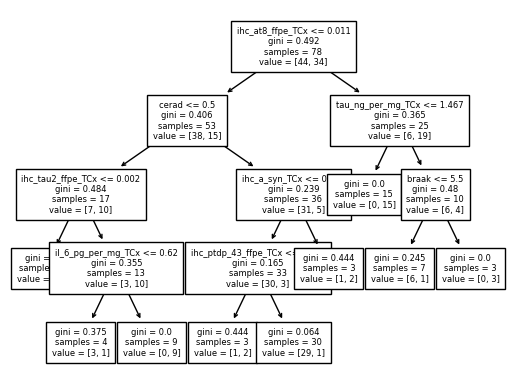

In [57]:
clf = DecisionTreeClassifier(max_leaf_nodes = 9, random_state = 315)
models = chek_features(X, y, clf, RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77))
plot_tree(models[7], feature_names = X.columns, fontsize = 6)

[Text(0.4583333333333333, 0.9, 'ihc_gfap_ffpe_TCx <= 0.025\ngini = 0.492\nsamples = 78\nvalue = [44, 34]'),
 Text(0.25, 0.7, 'ihc_tau2_ffpe_TCx <= 0.004\ngini = 0.369\nsamples = 41\nvalue = [31, 10]'),
 Text(0.16666666666666666, 0.5, 'ihc_a_syn_TCx <= 0.0\ngini = 0.272\nsamples = 37\nvalue = [31, 6]'),
 Text(0.08333333333333333, 0.3, 'gini = 0.202\nsamples = 35\nvalue = [31, 4]'),
 Text(0.25, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.6666666666666666, 0.7, 'tau_ng_per_mg_TCx <= 1.467\ngini = 0.456\nsamples = 37\nvalue = [13, 24]'),
 Text(0.5, 0.5, 'ihc_a_syn_TCx <= 0.0\ngini = 0.198\nsamples = 18\nvalue = [2, 16]'),
 Text(0.4166666666666667, 0.3, 'gini = 0.0\nsamples = 16\nvalue = [0, 16]'),
 Text(0.5833333333333334, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8333333333333334, 0.5, 'ihc_a_beta_TCx <= 0.006\ngini = 0.488\nsamples = 19\nvalue = [11, 8]'),
 Text(0.75, 0.3, 'il_6_pg_per_

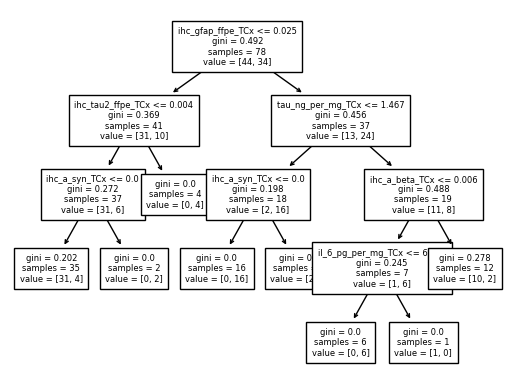

In [58]:
clf = DecisionTreeClassifier(max_leaf_nodes = 8, random_state = 315)
models = chek_features(X, y, clf,
                       RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315))
plot_tree(models[7], feature_names = X.columns, fontsize = 6)

[Text(0.6666666666666666, 0.9285714285714286, 'ihc_at8_TCx <= 0.031\ngini = 0.492\nsamples = 78\nvalue = [44, 34]'),
 Text(0.5555555555555556, 0.7857142857142857, 'ptau_over_tau_ratio_TCx <= 0.522\ngini = 0.457\nsamples = 68\nvalue = [44, 24]'),
 Text(0.3333333333333333, 0.6428571428571429, 'il_6_pg_per_mg_TCx <= 5.3\ngini = 0.5\nsamples = 43\nvalue = [22, 21]'),
 Text(0.2222222222222222, 0.5, 'education_years <= 14.5\ngini = 0.486\nsamples = 36\nvalue = [15, 21]'),
 Text(0.1111111111111111, 0.35714285714285715, 'gini = 0.386\nsamples = 23\nvalue = [6, 17]'),
 Text(0.3333333333333333, 0.35714285714285715, 'ihc_gfap_ffpe_TCx <= 0.024\ngini = 0.426\nsamples = 13\nvalue = [9, 4]'),
 Text(0.2222222222222222, 0.21428571428571427, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.4444444444444444, 0.21428571428571427, 'ihc_gfap_ffpe_TCx <= 0.028\ngini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(0.3333333333333333, 0.07142857142857142, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.5

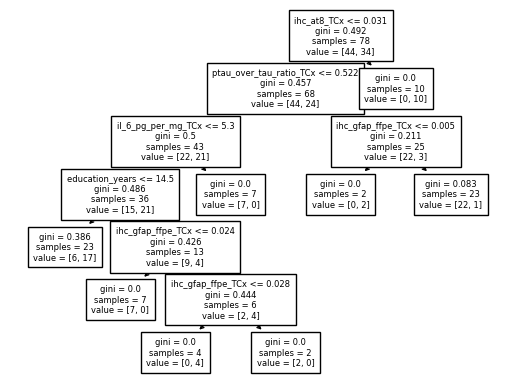

In [59]:
clf = DecisionTreeClassifier(max_leaf_nodes = 8, random_state = 315)
models = chek_features(X, y, clf, 
                       RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 419))
plot_tree(models[7], feature_names = X.columns, fontsize = 6)

### Model 2. Random Forest (non-parametric)

In [60]:
def rf_fit(X, y, cv, max_node = 20):
  '''
  Initial random forest
  '''
  max_nodes = list(range(5, max_node + 1))
  train_scores = []
  test_scores = []
  train_variation = []
  test_variation = []

  for i in tqdm(max_nodes):
    train_score = []
    test_score = []
    for j, (train_idx, test_idx) in enumerate(cv.split(X,y)):
      clf = RandomForestClassifier(n_estimators = 50, max_leaf_nodes = i,
                                   bootstrap = False, random_state = 315)
      X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
      y_train, y_test = y[train_idx], y[test_idx]
      clf.fit(X_train, y_train)
      train_score.append(roc_auc_score(y_train, clf.predict(X_train)))
      test_score.append(roc_auc_score(y_test, clf.predict(X_test)))
  
    mean_train_score = np.mean(train_score)
    std_train_score = np.std(train_score)
    mean_test_score = np.mean(test_score)
    std_test_score = np.std(test_score)
  
    train_scores.append(mean_train_score)
    test_scores.append(mean_test_score)
    train_variation.append(std_train_score)
    test_variation.append(std_test_score)
  
  return train_scores, test_scores, train_variation, test_variation

100%|██████████| 16/16 [01:23<00:00,  5.23s/it]


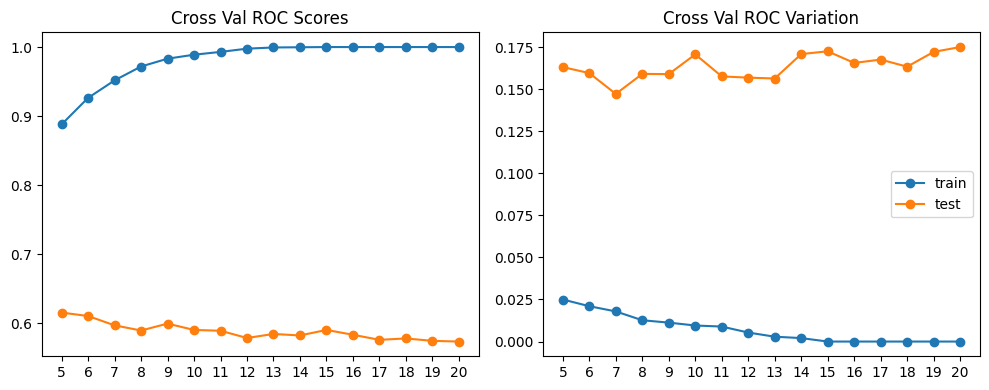

In [61]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77)
max_nodes = list(range(5, 21))

model_2_1 = rf_fit(X, y, cv)
plot_roc(max_nodes, model_2_1[0], model_2_1[1], model_2_1[2], model_2_1[3])

100%|██████████| 16/16 [01:17<00:00,  4.85s/it]


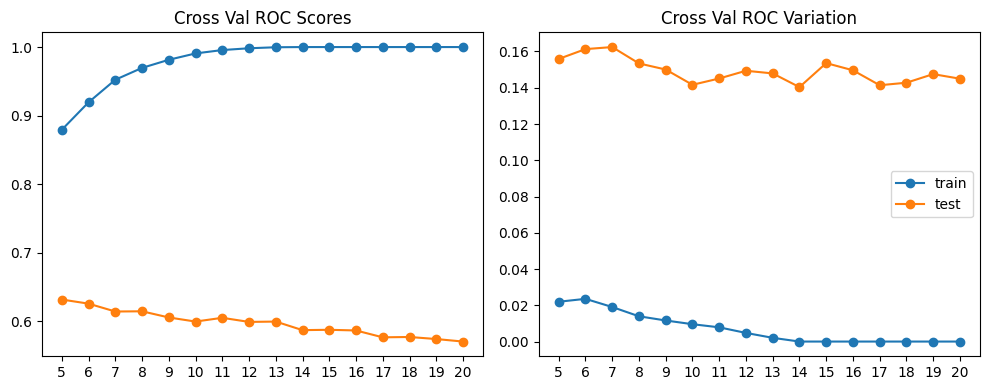

In [62]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315)
model_2_2 = rf_fit(X, y, cv)
plot_roc(max_nodes, model_2_2[0], model_2_2[1], model_2_2[2], model_2_2[3])

100%|██████████| 16/16 [01:21<00:00,  5.07s/it]


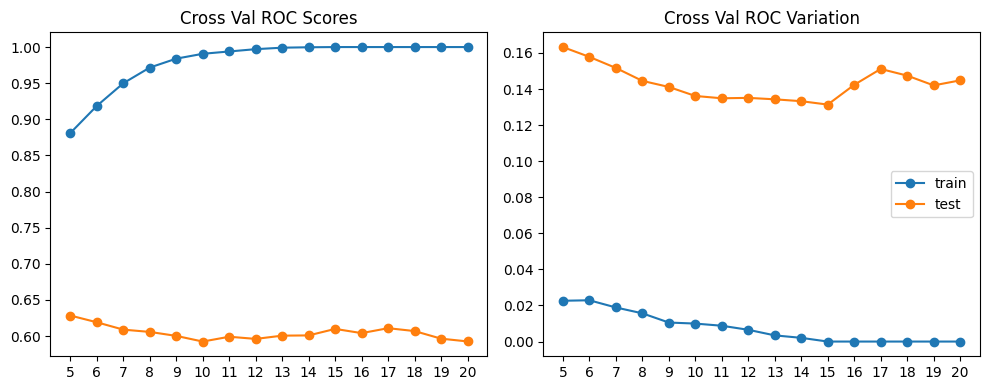

In [63]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 419)
model_2_3 = rf_fit(X, y, cv)
plot_roc(max_nodes, model_2_3[0], model_2_3[1], model_2_3[2], model_2_3[3])

In [64]:
clf = RandomForestClassifier(max_leaf_nodes = 10, random_state = 315)

models = chek_features(X, y, clf,
                       RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77))
feature_imp = [i.feature_importances_ for i in models]
np.argsort(np.sum(feature_imp, axis = 0))[::-1]

array([19, 20, 16, 18, 23, 22,  5, 21, 15, 34, 30, 29, 32,  8, 13, 17, 36,
        3, 31, 28,  0, 27, 12, 11, 26, 35,  9, 33, 24, 25, 14, 10,  1,  6,
        7,  2,  4])

In [65]:
models = chek_features(X, y, clf,
                       RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315))
feature_imp = [i.feature_importances_ for i in models]
np.argsort(np.sum(feature_imp, axis = 0))[::-1]

array([20, 18, 16, 19, 34, 22,  3, 23, 21, 15, 30, 17, 32,  0, 31, 27, 26,
        8, 33, 29, 10, 28, 13, 36, 35, 14,  9, 11, 12, 25, 24,  5,  6,  2,
        7,  1,  4])

In [66]:
models = chek_features(X, y, clf,
                       RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 419))
feature_imp = [i.feature_importances_ for i in models]
np.argsort(np.sum(feature_imp, axis = 0))[::-1]

array([20, 18, 23, 19,  3, 22, 16, 17, 21, 34, 15, 29, 30, 32, 11, 31, 36,
        0, 33, 27, 12,  8,  5, 35, 14, 28,  9, 13, 26, 10, 24, 25,  6,  1,
        2,  7,  4])

In [67]:
X.columns[np.array([20, 18, 19, 16, 23, 22])].tolist()

['ihc_gfap_ffpe_TCx',
 'ihc_at8_TCx',
 'ihc_at8_ffpe_TCx',
 'ihc_a_beta_ffpe_TCx',
 'ihc_tau2_ffpe_TCx',
 'ihc_ptdp_43_ffpe_TCx']

## Model 3. Unsupervised Learning PCA and KMeans & GLM with PCs

### Model 3: PCA & GLM Model with PCs

In [68]:
X, y = prepare_for_glm()
pca = PCA(n_components = 10)
pca.fit(X)

PCA(n_components=10)

In [69]:
print(pca.explained_variance_ratio_[:5])
print(sum(pca.explained_variance_ratio_[:5]))

[0.32291038 0.27514877 0.13290172 0.07979339 0.06011382]
0.8708680770948406


In [70]:
pd.DataFrame(pca.components_[0][np.argsort(abs(pca.components_[0]))[::-1]][:7],
             index = X.columns[np.argsort(abs(pca.components_[0]))[::-1]][:7])

0
ab42_pg_per_mg_TCx       -0.691563
ab42_over_ab40_ratio_TCx -0.553903
education_years           0.252231
age                      -0.191629
braak                    -0.184936
cerad                    -0.149268
nia_reagan               -0.103730

In [71]:
pd.DataFrame(pca.components_[1][np.argsort(abs(pca.components_[1]))[::-1]][:7],
             index = X.columns[np.argsort(abs(pca.components_[1]))[::-1]][:7])

0
age                      -0.864819
education_years           0.335710
ab42_over_ab40_ratio_TCx  0.208123
ab42_pg_per_mg_TCx        0.156602
rantes_pg_per_mg_TCx      0.124299
mcp_1_pg_per_mg_TCx       0.117489
mip_1a_pg_per_mg_TCx      0.090391

In [72]:
pd.DataFrame(pca.components_[2][np.argsort(abs(pca.components_[2]))[::-1]][:7],
             index = X.columns[np.argsort(abs(pca.components_[2]))[::-1]][:7])

0
education_years      -0.847409
age                  -0.433109
ab40_pg_per_mg_TCx   -0.139929
ab42_pg_per_mg_TCx   -0.120712
mcp_1_pg_per_mg_TCx  -0.111899
rantes_pg_per_mg_TCx -0.111463
il_7_pg_per_mg_TCx   -0.104606

In [73]:
pd.DataFrame(pca.components_[3][np.argsort(abs(pca.components_[3]))[::-1]][:7],
             index = X.columns[np.argsort(abs(pca.components_[3]))[::-1]][:7])

0
ab42_over_ab40_ratio_TCx -0.626477
ab40_pg_per_mg_TCx        0.587657
braak                     0.280638
ab42_pg_per_mg_TCx        0.241193
cerad                     0.196044
nia_reagan                0.177409
mip_1a_pg_per_mg_TCx      0.107216

In [74]:
def var_score(X, y, pca, cv):
  scores = []
  features = []
  for i, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    X_train = X.iloc[train_idx, :]
    pca.fit(X_train)
    scores.append(sum(pca.explained_variance_ratio_[:5]))
    for j in range(5):
      features += X.columns[np.argsort(abs(pca.components_[j]))[::-1]][:7].tolist()
  return scores, features

In [75]:
def pca_glm(X, y, cv, thres = 0.5, null = False):
  pca = PCA(n_components = 5)
  X = pd.DataFrame(pca.fit_transform(X), columns = ['PC' + str(i) for i in range(1,6)])
  X = sm.add_constant(X)
  models = []
  roc = []
  acc = []
  if null:
    X = X[['const']]
  for train_idx, test_idx in cv.split(X, y):
      X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
      y_train, y_test = y[train_idx], y[test_idx]
      glm = sm.GLM(y_train, X_train, family = sm.families.Binomial()).fit(maxiter = 100)
      models.append(glm)
      y_pred = glm.predict(X_test)

      y_pred[y_pred >= thres] = 1
      y_pred[y_pred < thres] = 0
      roc.append(roc_auc_score(y_test, y_pred))
      acc.append(accuracy_score(y_test, y_pred))
  return models, roc, acc

###### null glm

In [76]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77)
models_3_0, roc, acc = pca_glm(X, y, cv, thres = 0.5, null = True)
models_3_0[7].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     nincds_arda_diagnosis   No. Observations:                   78
Model:                               GLM   Df Residuals:                       77
Model Family:                   Binomial   Df Model:                            0
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -53.655
Date:                   Sat, 15 Apr 2023   Deviance:                       107.31
Time:                           08:16:04   Pearson chi2:                     78.0
No. Iterations:                        4   Pseudo R-squ. (CS):          3.331e-16
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2059      0.228     -0.904      0.366      -0.652       0.240
==============================================================================
"""

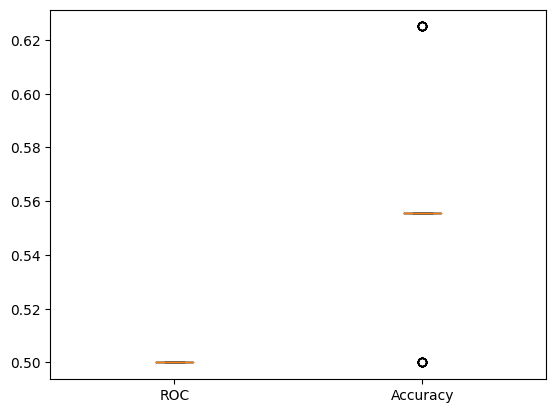

In [77]:
plt.boxplot([roc, acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.show()

###### 1st pca glm

In [78]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77)
scores, features = var_score(X, y, pca, cv)
print('Mean var explain ratio:', np.mean(scores))
print('Varation:', np.std(scores))
dic = {}
for i in features:
  if i not in dic:
    dic[i] = 1
  else:
    dic[i] += 1
dic

Mean var explain ratio: 0.8721965593675028
Varation: 0.00454580567796918


{'ab42_pg_per_mg_TCx': 192,
 'ab42_over_ab40_ratio_TCx': 160,
 'education_years': 210,
 'braak': 155,
 'cerad': 124,
 'mcp_1_pg_per_mg_TCx': 169,
 'rantes_pg_per_mg_TCx': 164,
 'age': 152,
 'mip_1a_pg_per_mg_TCx': 120,
 'ab40_pg_per_mg_TCx': 104,
 'il_7_pg_per_mg_TCx': 93,
 'nia_reagan': 78,
 'il_6_pg_per_mg_TCx': 21,
 'vegf_pg_per_mg_TCx': 7,
 'isoprostane_pg_per_mg_TCx': 1}

In [79]:
models_3_1, roc, acc = pca_glm(X, y, cv, thres = 0.5)
models_3_1[7].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     nincds_arda_diagnosis   No. Observations:                   78
Model:                               GLM   Df Residuals:                       72
Model Family:                   Binomial   Df Model:                            5
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -48.792
Date:                   Sat, 15 Apr 2023   Deviance:                       97.585
Time:                           08:16:05   Pearson chi2:                     78.4
No. Iterations:                        4   Pseudo R-squ. (CS):             0.1172
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2024      0.243     -0.834      0.404      -0.678       0.273
PC1           -0.0966      0.054     -1.787      0.074      -0.202       0.009
PC2           -0.0725      0.060     -1.210      0.226      -0.190       0.045
PC3            0.1336      0.087      1.530      0.126      -0.038       0.305
PC4            0.1433      0.110      1.307      0.191      -0.072       0.358
PC5            0.1135      0.125      0.910      0.363      -0.131       0.358
==============================================================================
"""

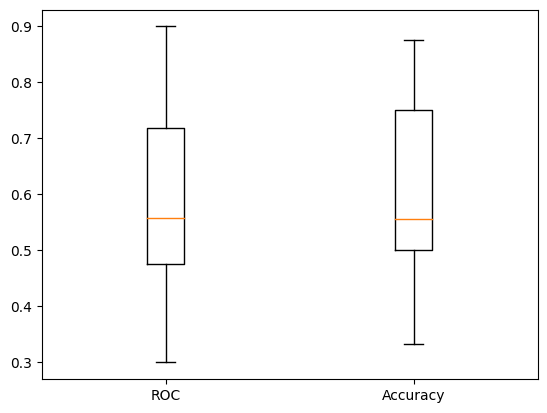

In [80]:
plt.boxplot([roc, acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.show()

###### 2nd pca glm

In [81]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315)
scores, features = var_score(X, y, pca, cv)
print('Mean var explain ratio:', np.mean(scores))
print('Varation:', np.std(scores))
dic = {}
for i in features:
  if i not in dic:
    dic[i] = 1
  else:
    dic[i] += 1
dic

Mean var explain ratio: 0.8721975707393219
Varation: 0.004494957681173493


{'ab42_pg_per_mg_TCx': 186,
 'ab42_over_ab40_ratio_TCx': 156,
 'age': 151,
 'education_years': 209,
 'braak': 151,
 'cerad': 135,
 'rantes_pg_per_mg_TCx': 159,
 'mcp_1_pg_per_mg_TCx': 171,
 'mip_1a_pg_per_mg_TCx': 129,
 'ab40_pg_per_mg_TCx': 103,
 'il_7_pg_per_mg_TCx': 92,
 'nia_reagan': 77,
 'il_6_pg_per_mg_TCx': 24,
 'vegf_pg_per_mg_TCx': 7}

In [82]:
models_3_2, roc, acc = pca_glm(X, y, cv, thres = 0.5)
models_3_2[7].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     nincds_arda_diagnosis   No. Observations:                   78
Model:                               GLM   Df Residuals:                       72
Model Family:                   Binomial   Df Model:                            5
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -48.581
Date:                   Sat, 15 Apr 2023   Deviance:                       97.163
Time:                           08:16:06   Pearson chi2:                     77.7
No. Iterations:                        4   Pseudo R-squ. (CS):             0.1220
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2535      0.245     -1.036      0.300      -0.733       0.226
PC1           -0.0674      0.055     -1.225      0.220      -0.175       0.040
PC2           -0.0688      0.062     -1.118      0.263      -0.189       0.052
PC3            0.1463      0.089      1.641      0.101      -0.028       0.321
PC4            0.2003      0.111      1.800      0.072      -0.018       0.418
PC5            0.1248      0.127      0.981      0.327      -0.125       0.374
==============================================================================
"""

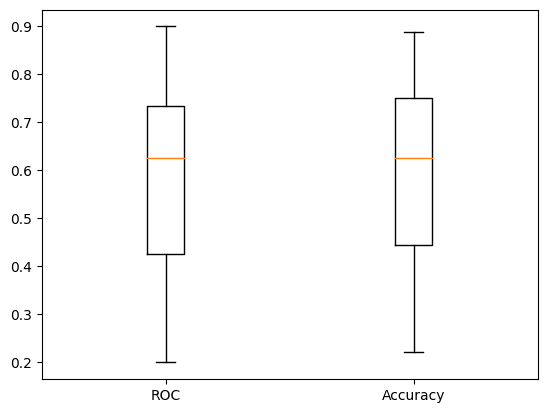

In [83]:
plt.boxplot([roc, acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.show()

###### 3rd pca glm

In [84]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 419)
scores, features = var_score(X, y, pca, cv)
print('Mean var explain ratio:', np.mean(scores))
print('Varation:', np.std(scores))
dic = {}
for i in features:
  if i not in dic:
    dic[i] = 1
  else:
    dic[i] += 1
dic

Mean var explain ratio: 0.8721735818941129
Varation: 0.004702750876539108


{'ab42_pg_per_mg_TCx': 183,
 'ab42_over_ab40_ratio_TCx': 155,
 'education_years': 208,
 'age': 152,
 'braak': 162,
 'cerad': 127,
 'ab40_pg_per_mg_TCx': 106,
 'rantes_pg_per_mg_TCx': 159,
 'mcp_1_pg_per_mg_TCx': 175,
 'mip_1a_pg_per_mg_TCx': 130,
 'il_7_pg_per_mg_TCx': 90,
 'nia_reagan': 80,
 'il_6_pg_per_mg_TCx': 18,
 'vegf_pg_per_mg_TCx': 5}

In [85]:
models_3_3, roc, acc = pca_glm(X, y, cv, thres = 0.5)
models_3_3[7].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     nincds_arda_diagnosis   No. Observations:                   78
Model:                               GLM   Df Residuals:                       72
Model Family:                   Binomial   Df Model:                            5
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -49.555
Date:                   Sat, 15 Apr 2023   Deviance:                       99.111
Time:                           08:16:06   Pearson chi2:                     77.6
No. Iterations:                        4   Pseudo R-squ. (CS):            0.09977
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2433      0.243     -1.002      0.316      -0.719       0.232
PC1           -0.0547      0.053     -1.027      0.305      -0.159       0.050
PC2           -0.0533      0.061     -0.878      0.380      -0.172       0.066
PC3            0.1417      0.093      1.526      0.127      -0.040       0.324
PC4            0.1890      0.111      1.705      0.088      -0.028       0.406
PC5            0.0820      0.125      0.654      0.513      -0.164       0.328
==============================================================================
"""

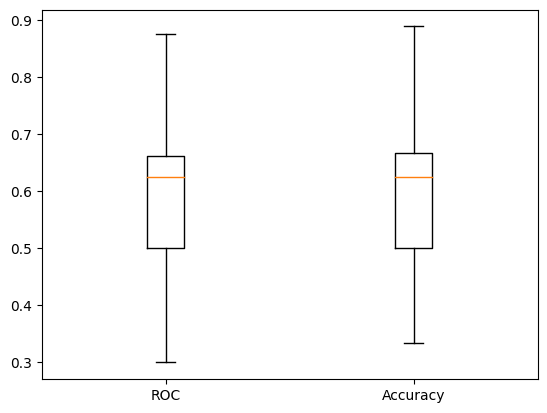

In [86]:
plt.boxplot([roc, acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.show()

### Clustering

In [87]:
def perform_kmeans(X, y, cv):
  res = []
  std = []
  for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, n_init = 'auto', random_state = 315)
    score = []
    for idx, _ in cv.split(X,y):
      x = X.iloc[idx]
      label = kmeans.fit_predict(x)
      sil = silhouette_score(x, label)
      score.append(sil)
    scores = np.mean(score)
    var = np.std(score)
    res.append(scores)
    std.append(var)
  return res, std

In [88]:
def plot_kmeans(xaxis, res, std):
  fig, axs = plt.subplots(1, 2, figsize = (10, 4))
  axs[0].plot(xaxis, res, marker = 'o')
  axs[0].set_title('Cross Val Sil Scores')
  axs[0].set_xticks(xaxis)
  axs[1].plot(xaxis, std, marker = 'o')
  axs[1].set_title('Cross Val Sil Variation')
  axs[1].set_xticks(xaxis)

  fig.tight_layout()
  plt.show()

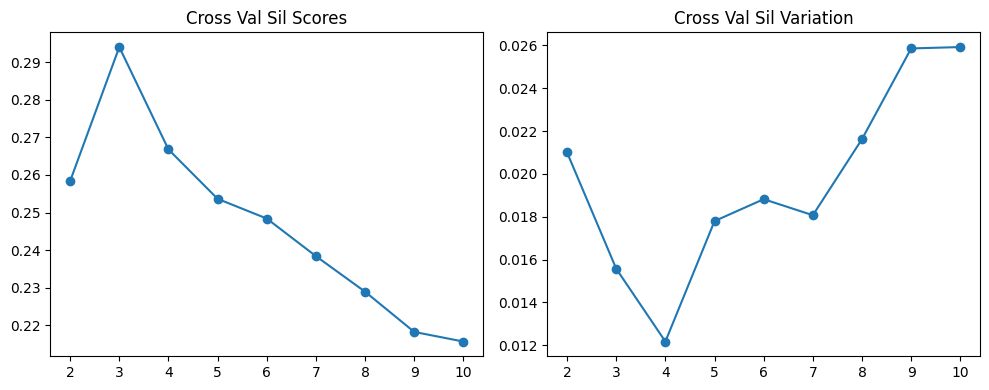

In [89]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77)

res, std = perform_kmeans(X, y, cv)
plot_kmeans(range(2, 11), res, std)

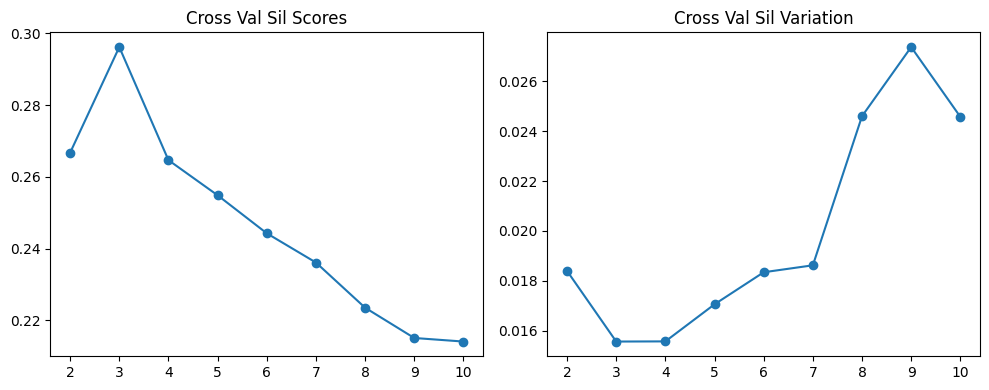

In [90]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315)

res, std = perform_kmeans(X, y, cv)
plot_kmeans(range(2, 11), res, std)

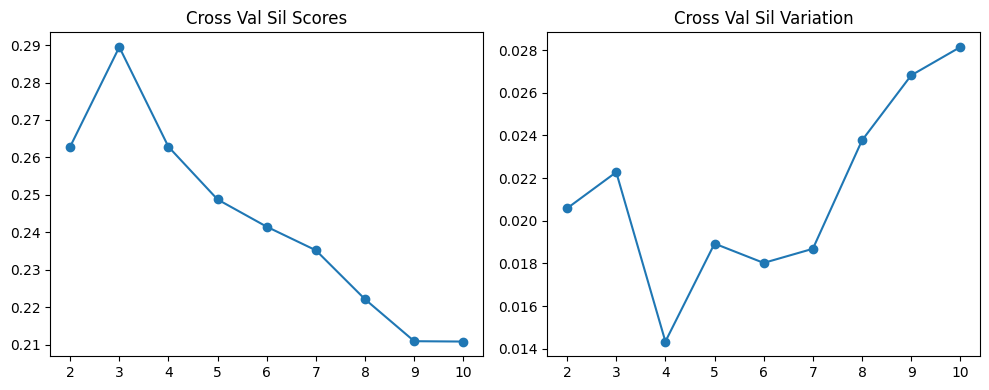

In [91]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 419)

res, std = perform_kmeans(X, y, cv)
plot_kmeans(range(2, 11), res, std)

In [92]:
X, y = prepare_for_glm()
km = KMeans(n_clusters = 2, n_init = 'auto', random_state = 315)
X['label'] = km.fit_predict(X)
temp = X.groupby('label').mean().diff().iloc[-1].abs()
temp = pd.DataFrame({'Diff': temp.values, 'Min': X.min(axis = 0).iloc[:-1, ].values,
              'Max': X.max(axis = 0).iloc[:-1, ].values}, index = temp.index)
temp['ratio'] = temp['Diff']/(temp['Max'] - temp['Min'])
temp.sort_values(by = ['ratio'], ascending = False)

Diff       Min        Max     ratio
ab42_pg_per_mg_TCx         6.376222  0.000000   8.295742  0.768614
ab42_over_ab40_ratio_TCx   4.505612  0.000000  10.000000  0.450561
cerad                      1.282468  0.000000   3.000000  0.427489
ihc_a_beta_TCx             0.123495  0.086914   0.442394  0.347405
nia_reagan                 0.858225  0.000000   3.000000  0.286075
ptau_ng_per_mg_TCx         0.406416  0.000000   1.600194  0.253980
tau_ng_per_mg_TCx          0.306006  0.000000   1.221122  0.250594
braak                      1.403680  0.000000   6.000000  0.233947
ptau_over_tau_ratio_TCx    0.284943  0.000000   1.548333  0.184032
ihc_at8_TCx                0.080020  0.026481   0.463085  0.183278
a_syn_pg_per_mg_TCx        0.144787  0.000000   0.829134  0.174624
ihc_at8_ffpe_TCx           0.060891  0.000000   0.367769  0.165567
il_7_pg_per_mg_TCx         0.512256  0.000000   3.193868  0.160387
isoprostane_pg_per_mg_TCx  0.254162  0.000000   1.787695  0.142173
ihc_a_beta_ffpe_TCx        0.054993  0.000000   0.410748  0.133885
apo_e4_allele              0.129870  0.000000   1.000000  0.129870
il_6_pg_per_mg_TCx         0.511844  0.000000   4.091635  0.125095
mcp_1_pg_per_mg_TCx        0.743605  0.000000   6.392145  0.116331
ab40_pg_per_mg_TCx         0.948973  0.000000   8.669202  0.109465
education_years            1.589827  6.000000  21.000000  0.105988
ihc_gfap_ffpe_TCx          0.041882  0.000000   0.414218  0.101111
num_tbi_w_loc              0.282468  0.000000   3.000000  0.094156
ever_tbi_w_loc             0.090909  0.000000   1.000000  0.090909
ever_tbi                   0.090909  0.000000   1.000000  0.090909
vegf_pg_per_mg_TCx         0.180448  0.000000   2.034405  0.088698
rantes_pg_per_mg_TCx       0.497144  0.000000   5.793532  0.085810
ihc_tau2_ffpe_TCx          0.025008  0.000000   0.336070  0.074413
mip_1a_pg_per_mg_TCx       0.559594  0.000000   7.613158  0.073504
age                        0.929654  1.000000  14.000000  0.071512
tnf_a_pg_per_mg_TCx        0.112279  0.000000   1.914751  0.058639
sex                        0.051948  0.000000   1.000000  0.051948
ihc_ptdp_43_ffpe_TCx       0.004306  0.079256   0.166581  0.049308
ifn_g_pg_per_mg_TCx        0.043981  0.000000   1.308427  0.033613
ihc_a_syn_TCx              0.002800  0.027558   0.218691  0.014652
il_4_pg_per_mg_TCx         0.017597  0.000000   1.691538  0.010403
il_10_pg_per_mg_TCx        0.003144  0.000000   1.472076  0.002136
ihc_iba1_ffpe_TCx          0.000257  0.245489   0.466449  0.001165

In [93]:
temp.sort_values(by = ['ratio'], ascending = False)[:7]

Diff       Min        Max     ratio
ab42_pg_per_mg_TCx        6.376222  0.000000   8.295742  0.768614
ab42_over_ab40_ratio_TCx  4.505612  0.000000  10.000000  0.450561
cerad                     1.282468  0.000000   3.000000  0.427489
ihc_a_beta_TCx            0.123495  0.086914   0.442394  0.347405
nia_reagan                0.858225  0.000000   3.000000  0.286075
ptau_ng_per_mg_TCx        0.406416  0.000000   1.600194  0.253980
tau_ng_per_mg_TCx         0.306006  0.000000   1.221122  0.250594

## Model 4, 5, 6. GLM Lasso and stepwise selection(parametric)

### Model 4. Lasso (L1 regularization)

In [94]:
def lasso_glm(X, y, cv, thres = 0.5):
  '''
  any interaction?
  '''
  X = sm.add_constant(X)
  cols = X.columns.tolist()
  models = []
  roc = []
  acc = []
  for train_idx, test_idx in cv.split(X, y):
      X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
      y_train, y_test = y[train_idx], y[test_idx]
      glm = sm.GLM(y_train, X_train, family = sm.families.Binomial()
                  ).fit_regularized(alpha = 1, L1_wt = 1, maxiter = 100)
      models.append(glm)
      y_pred = glm.predict(X_test)

      y_pred[y_pred >= thres] = 1
      y_pred[y_pred < thres] = 0
      roc.append(roc_auc_score(y_test, y_pred))
      acc.append(accuracy_score(y_test, y_pred))
  return models, roc, acc

In [95]:
def show_count(models):
  idx = []
  vals = []
  dict_ = {}
  for i in models:
    idx.extend(i.params.index[i.params.values != 0])
    vals.extend(i.params.values[i.params.values != 0])
  for i in idx:
    if i in dict_.keys():
      dict_[i] += 1
    else:
      dict_[i] = 1
  return dict_, np.mean(vals)

In [96]:
X, y = prepare_for_glm()

###### 1st lasso

In [97]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 77)
models_4_1, roc, acc = lasso_glm(X, y, cv)

show_count(models_4_1)

({'education_years': 50}, -0.003984941938792324)

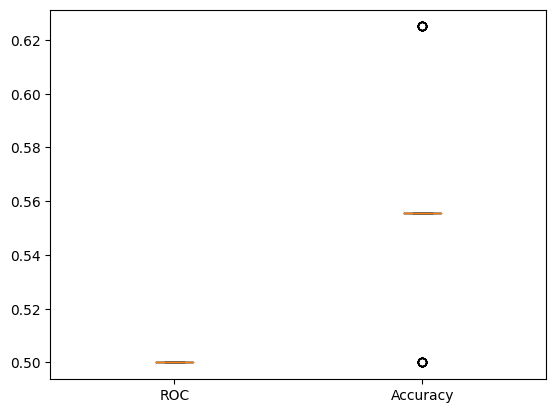

In [98]:
plt.boxplot([roc, acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.show()

###### 2nd lasso

In [99]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315)
models_4_2, roc, acc = lasso_glm(X, y, cv)

show_count(models_4_2)

({'education_years': 49}, -0.004075950803008663)

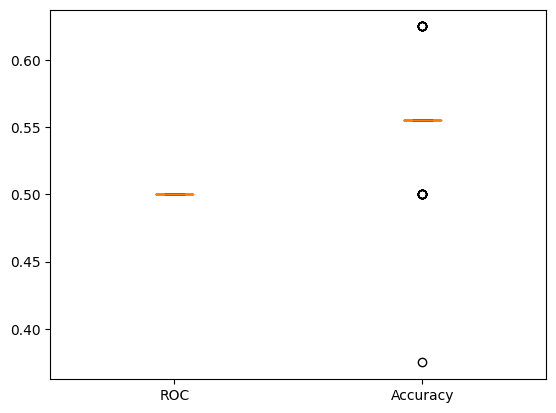

In [100]:
plt.boxplot([roc, acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.show()

###### 3rd lasso

In [101]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 419)
models_4_3, roc, acc = lasso_glm(X, y, cv)

show_count(models_4_3)

({'education_years': 50}, -0.003982832872299502)

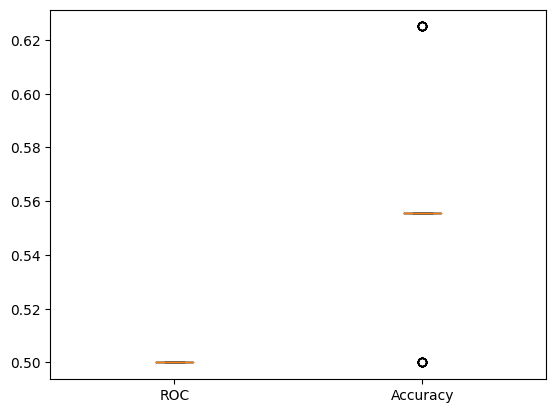

In [102]:
plt.boxplot([roc, acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.show()

### Model 5 & 6. Stepwise selection (parametric, forward and backward)

In [103]:
class stepwise_selection:
  def __init__(self, seed = None):
      self.cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = seed)
  
  def _forward(self, X, y):
    cols = X.columns.tolist()
    X = sm.add_constant(X, has_constant='add')
    current_cols = ['const']
    best_aic = np.inf
    while len(cols):
      aic_store = []
      for col in cols:
        x = X[current_cols + [col]]
        model = sm.GLM(y, x, family = sm.families.Binomial()).fit()
        aic_store.append((model.aic, col, model))
      new_aic, new_col, new_model = min(aic_store)
      
      if new_aic < best_aic:
        cols.remove(new_col)
        current_cols.append(new_col)
        best_aic = new_aic
        best_model = new_model
      else:
        break
    return best_model, current_cols, best_aic
  
  def _backward(self, X, y):
    cols = X.columns.tolist()
    X = sm.add_constant(X, has_constant='add')
    best_bic = np.inf
    err_msgs = 0
    count = 0
    while len(cols):
      bic_store = []
      for col in combinations(cols, len(cols) - 1):
        x = X[['const'] + list(col)]
        try:
          model = sm.GLM(y, x, family = sm.families.Binomial()).fit()
          bic_store.append((model.bic, col, model))
        except:
          err_msgs += 1
        count += 1
      new_bic, new_cols, new_model = min(bic_store)

      if new_bic < best_bic:
        cols = list(new_cols)
        best_bic = new_bic
        best_model = new_model
      else:
        break
    return best_model, ['const'] + cols, best_bic, err_msgs, count

  def cross_val(self, X, y, direction, thres = 0.5):
    train_aic = []
    test_roc = []
    test_acc = []
    models = []
    if direction == 'forward':
      for train_idx, test_idx in self.cv.split(X, y):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]
        
        model, feature, score = self._forward(X_train, y_train)
        X_test = sm.add_constant(X_test, has_constant = 'add')
        y_pred = model.predict(X_test[feature])

        y_pred[y_pred >= thres] = 1
        y_pred[y_pred < thres] = 0

        train_aic.append(score)
        models.append(model)
        test_roc.append(roc_auc_score(y_test, y_pred))
        test_acc.append(accuracy_score(y_test, y_pred))
      
      return train_aic, test_roc, test_acc, models

    elif direction == 'backward':
      err_total = 0
      count = 0
      for train_idx, test_idx in self.cv.split(X, y):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]
        
        model, feature, score, err_msgs, cnt = self._backward(X_train, y_train)
        X_test = sm.add_constant(X_test, has_constant='add')
        y_pred = model.predict(X_test[feature])
        err_total += err_msgs
        count += cnt

        y_pred[y_pred >= thres] = 1
        y_pred[y_pred < thres] = 0

        train_aic.append(score)
        models.append(model)
        test_roc.append(roc_auc_score(y_test, y_pred))
        test_acc.append(accuracy_score(y_test, y_pred))

      return train_aic, test_roc, test_acc, models, err_total, count

In [104]:
def count_variables(models):
  cnt_list = []
  for i in models:
    cnt_list.extend(i.params.index.tolist())
  res = {}
  for i in cnt_list:
    if i not in res:
      res[i] = 1
    else:
      res[i] += 1
  return res

In [105]:
X, y = prepare_for_glm()

###### 1st stepwise

In [106]:
stepwise1 = stepwise_selection(seed = 77)

f_train_aic, f_test_roc, f_test_acc, model_5_1 = stepwise1.cross_val(X, y, 'forward')
b_train_aic, b_test_roc, b_test_acc, model_6_1, error_times, total= stepwise1.cross_val(X, y, 'backward')
print('Perfect Separation error appears:', error_times, 'out of', total, 'iterations')

Perfect Separation error appears: 113 out of 34392 iterations


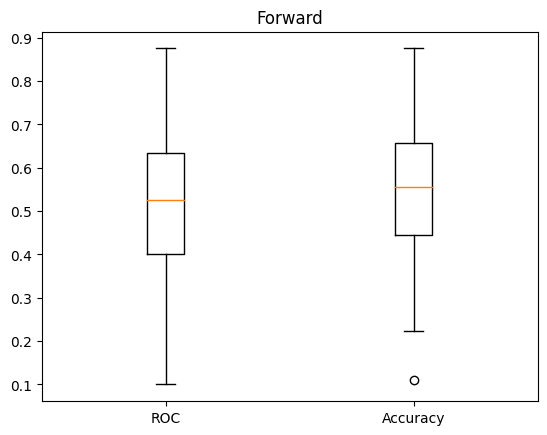

In [107]:
plt.boxplot([f_test_roc, f_test_acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.title('Forward')
plt.show()

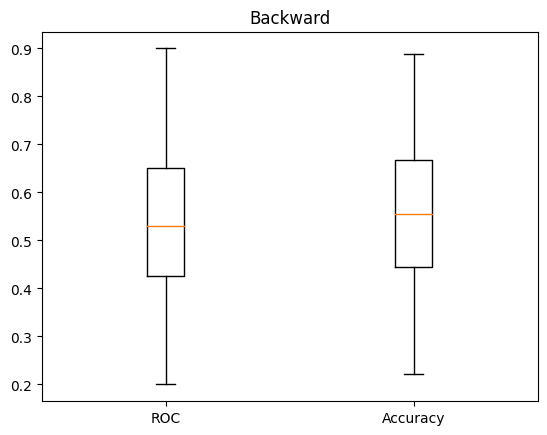

In [108]:
plt.boxplot([b_test_roc, b_test_acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.title('Backward')
plt.show()

In [109]:
print('Forward Model_5_1')
count_variables(model_5_1)

Forward Model_5_1


{'const': 50,
 'ihc_at8_TCx': 44,
 'ptau_over_tau_ratio_TCx': 5,
 'ihc_gfap_ffpe_TCx': 3,
 'mip_1a_pg_per_mg_TCx': 3,
 'mcp_1_pg_per_mg_TCx': 18,
 'il_6_pg_per_mg_TCx': 25,
 'il_7_pg_per_mg_TCx': 16,
 'education_years': 28,
 'ihc_ptdp_43_ffpe_TCx': 6,
 'ihc_tau2_ffpe_TCx': 4,
 'braak': 2,
 'ihc_a_syn_TCx': 8,
 'isoprostane_pg_per_mg_TCx': 5,
 'vegf_pg_per_mg_TCx': 5,
 'tnf_a_pg_per_mg_TCx': 1,
 'ihc_at8_ffpe_TCx': 5,
 'cerad': 3,
 'ifn_g_pg_per_mg_TCx': 2,
 'ihc_a_beta_TCx': 2,
 'ihc_a_beta_ffpe_TCx': 1,
 'apo_e4_allele': 1,
 'ab42_pg_per_mg_TCx': 1}

In [110]:
print('Backward Model_6_1')
count_variables(model_6_1)

Backward Model_6_1


{'const': 50,
 'ever_tbi': 40,
 'ever_tbi_w_loc': 40,
 'ihc_at8_ffpe_TCx': 27,
 'il_6_pg_per_mg_TCx': 28,
 'mcp_1_pg_per_mg_TCx': 27,
 'rantes_pg_per_mg_TCx': 1,
 'ihc_a_syn_TCx': 12,
 'il_7_pg_per_mg_TCx': 24,
 'braak': 5,
 'ihc_tau2_ffpe_TCx': 2,
 'ihc_at8_TCx': 17,
 'isoprostane_pg_per_mg_TCx': 5,
 'vegf_pg_per_mg_TCx': 3,
 'ihc_gfap_ffpe_TCx': 3,
 'a_syn_pg_per_mg_TCx': 2,
 'ab40_pg_per_mg_TCx': 1,
 'ab42_over_ab40_ratio_TCx': 2,
 'ab42_pg_per_mg_TCx': 4,
 'ihc_a_beta_TCx': 1,
 'ptau_ng_per_mg_TCx': 3,
 'ptau_over_tau_ratio_TCx': 3,
 'tau_ng_per_mg_TCx': 2,
 'nia_reagan': 1,
 'education_years': 3,
 'cerad': 2,
 'sex': 1,
 'apo_e4_allele': 1,
 'mip_1a_pg_per_mg_TCx': 1}

###### 2nd stepwise

In [111]:
stepwise2 = stepwise_selection(seed = 315)
f_train_aic, f_test_roc, f_test_acc, model_5_2 = stepwise2.cross_val(X, y, 'forward')
b_train_aic, b_test_roc, b_test_acc, model_6_2, error_times, total = stepwise2.cross_val(X, y, 'backward')
print('Perfect Separation error appears:', error_times, 'out of', total, 'iterations')

Perfect Separation error appears: 91 out of 33970 iterations


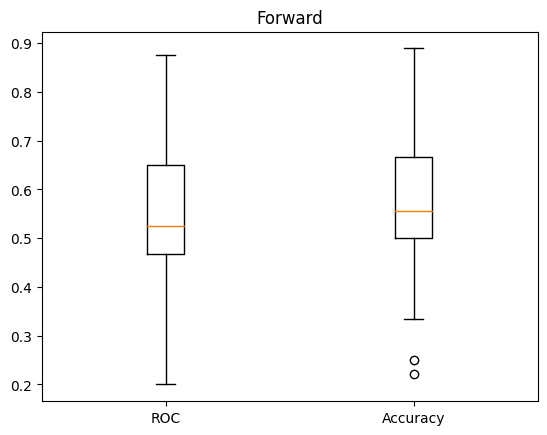

In [112]:
plt.boxplot([f_test_roc, f_test_acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.title('Forward')
plt.show()

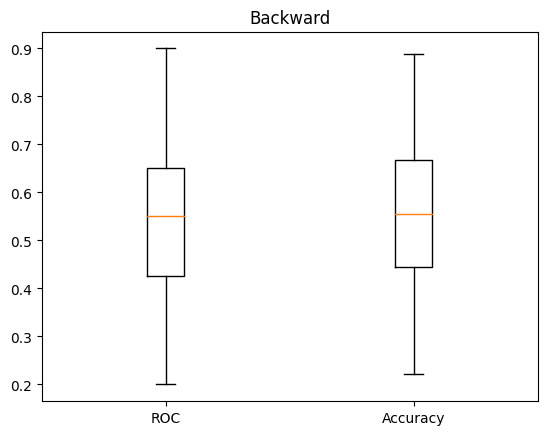

In [113]:
plt.boxplot([b_test_roc, b_test_acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.title('Backward')
plt.show()

In [114]:
print('Forward model_5_2')
count_variables(model_5_2)

Forward model_5_2


{'const': 50,
 'ihc_at8_TCx': 46,
 'education_years': 29,
 'il_6_pg_per_mg_TCx': 20,
 'mcp_1_pg_per_mg_TCx': 12,
 'il_7_pg_per_mg_TCx': 9,
 'ihc_gfap_ffpe_TCx': 1,
 'ihc_ptdp_43_ffpe_TCx': 8,
 'isoprostane_pg_per_mg_TCx': 4,
 'ihc_a_syn_TCx': 6,
 'ihc_at8_ffpe_TCx': 3,
 'ptau_over_tau_ratio_TCx': 1,
 'braak': 2,
 'ihc_tau2_ffpe_TCx': 4,
 'num_tbi_w_loc': 1,
 'cerad': 2,
 'mip_1a_pg_per_mg_TCx': 5,
 'ab42_pg_per_mg_TCx': 1,
 'ihc_a_beta_TCx': 1}

In [115]:
print('Backward model_6_2')
count_variables(model_6_2)

Backward model_6_2


{'const': 50,
 'ever_tbi': 39,
 'ever_tbi_w_loc': 39,
 'ihc_at8_TCx': 16,
 'ihc_at8_ffpe_TCx': 28,
 'il_6_pg_per_mg_TCx': 27,
 'il_7_pg_per_mg_TCx': 26,
 'mcp_1_pg_per_mg_TCx': 28,
 'ihc_gfap_ffpe_TCx': 4,
 'ptau_ng_per_mg_TCx': 3,
 'ptau_over_tau_ratio_TCx': 3,
 'vegf_pg_per_mg_TCx': 4,
 'ihc_a_syn_TCx': 14,
 'braak': 4,
 'education_years': 4,
 'isoprostane_pg_per_mg_TCx': 2,
 'mip_1a_pg_per_mg_TCx': 3,
 'tau_ng_per_mg_TCx': 2,
 'ab42_pg_per_mg_TCx': 2,
 'ihc_tau2_ffpe_TCx': 2,
 'age': 1,
 'sex': 1,
 'apo_e4_allele': 1,
 'cerad': 1,
 'nia_reagan': 1,
 'a_syn_pg_per_mg_TCx': 1,
 'ab40_pg_per_mg_TCx': 1,
 'ab42_over_ab40_ratio_TCx': 1,
 'ifn_g_pg_per_mg_TCx': 1,
 'ihc_a_beta_TCx': 1,
 'ihc_a_beta_ffpe_TCx': 1,
 'ihc_iba1_ffpe_TCx': 1,
 'ihc_ptdp_43_ffpe_TCx': 1,
 'il_10_pg_per_mg_TCx': 1,
 'il_4_pg_per_mg_TCx': 1,
 'rantes_pg_per_mg_TCx': 1,
 'tnf_a_pg_per_mg_TCx': 1}

###### 3rd stepwise

In [116]:
stepwise3 = stepwise_selection(seed = 419)
f_train_aic, f_test_roc, f_test_acc, model_5_3 = stepwise3.cross_val(X, y, 'forward')
b_train_aic, b_test_roc, b_test_acc, model_6_3, error_times, total = stepwise3.cross_val(X, y, 'backward')
print('Perfect Separation error appears:', error_times, 'out of', total, 'iterations')

Perfect Separation error appears: 93 out of 34518 iterations


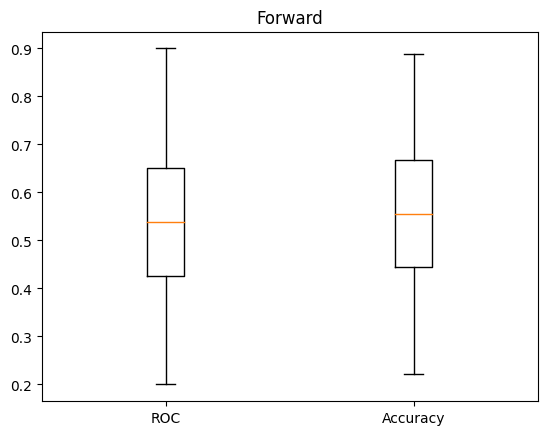

In [117]:
plt.boxplot([f_test_roc, f_test_acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.title('Forward')
plt.show()

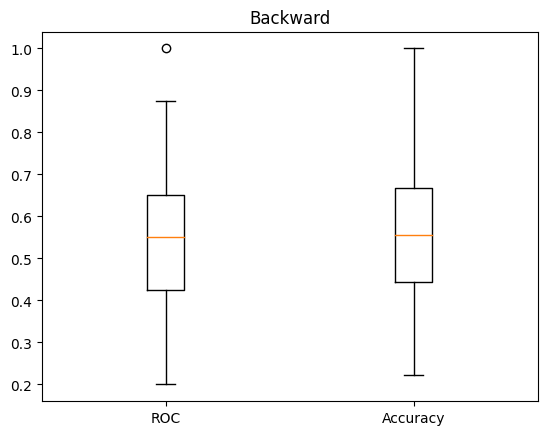

In [118]:
plt.boxplot([b_test_roc, b_test_acc])
plt.xticks([1, 2], ['ROC', 'Accuracy'])
plt.title('Backward')
plt.show()

In [119]:
print('Forward model_5_3')
count_variables(model_5_3)

Forward model_5_3


{'const': 50,
 'ihc_at8_TCx': 46,
 'education_years': 32,
 'ihc_a_syn_TCx': 7,
 'rantes_pg_per_mg_TCx': 2,
 'ihc_ptdp_43_ffpe_TCx': 7,
 'ptau_over_tau_ratio_TCx': 5,
 'il_6_pg_per_mg_TCx': 19,
 'mcp_1_pg_per_mg_TCx': 14,
 'apo_e4_allele': 2,
 'il_7_pg_per_mg_TCx': 10,
 'ihc_tau2_ffpe_TCx': 4,
 'vegf_pg_per_mg_TCx': 1,
 'cerad': 1,
 'mip_1a_pg_per_mg_TCx': 1,
 'isoprostane_pg_per_mg_TCx': 3,
 'ihc_gfap_ffpe_TCx': 1,
 'ab42_pg_per_mg_TCx': 1,
 'ifn_g_pg_per_mg_TCx': 1,
 'ihc_at8_ffpe_TCx': 1}

In [120]:
print('Backward model_6_3')
count_variables(model_6_3)

Backward model_6_3


{'const': 50,
 'ever_tbi': 41,
 'ever_tbi_w_loc': 41,
 'ihc_at8_TCx': 20,
 'il_6_pg_per_mg_TCx': 28,
 'il_7_pg_per_mg_TCx': 25,
 'mcp_1_pg_per_mg_TCx': 28,
 'ihc_a_syn_TCx': 13,
 'ihc_at8_ffpe_TCx': 25,
 'apo_e4_allele': 1,
 'education_years': 3,
 'braak': 3,
 'ihc_tau2_ffpe_TCx': 1,
 'vegf_pg_per_mg_TCx': 4,
 'sex': 1,
 'cerad': 1,
 'ab42_over_ab40_ratio_TCx': 3,
 'il_10_pg_per_mg_TCx': 1,
 'isoprostane_pg_per_mg_TCx': 3,
 'ptau_ng_per_mg_TCx': 1,
 'ptau_over_tau_ratio_TCx': 1,
 'ab40_pg_per_mg_TCx': 1,
 'ab42_pg_per_mg_TCx': 3,
 'ihc_a_beta_TCx': 1,
 'ihc_gfap_ffpe_TCx': 1}

In [121]:
model_5 = []
model_5.extend(model_5_1 + model_5_2 + model_5_3)
print('Forward Models')
count_variables(model_5)

Forward Models


{'const': 150,
 'ihc_at8_TCx': 136,
 'ptau_over_tau_ratio_TCx': 11,
 'ihc_gfap_ffpe_TCx': 5,
 'mip_1a_pg_per_mg_TCx': 9,
 'mcp_1_pg_per_mg_TCx': 44,
 'il_6_pg_per_mg_TCx': 64,
 'il_7_pg_per_mg_TCx': 35,
 'education_years': 89,
 'ihc_ptdp_43_ffpe_TCx': 21,
 'ihc_tau2_ffpe_TCx': 12,
 'braak': 4,
 'ihc_a_syn_TCx': 21,
 'isoprostane_pg_per_mg_TCx': 12,
 'vegf_pg_per_mg_TCx': 6,
 'tnf_a_pg_per_mg_TCx': 1,
 'ihc_at8_ffpe_TCx': 9,
 'cerad': 6,
 'ifn_g_pg_per_mg_TCx': 3,
 'ihc_a_beta_TCx': 3,
 'ihc_a_beta_ffpe_TCx': 1,
 'apo_e4_allele': 3,
 'ab42_pg_per_mg_TCx': 3,
 'num_tbi_w_loc': 1,
 'rantes_pg_per_mg_TCx': 2}

In [122]:
model_6 = []
model_6.extend(model_6_1 + model_6_2 + model_6_3)
print('Backward Models')
count_variables(model_6)

Backward Models


{'const': 150,
 'ever_tbi': 120,
 'ever_tbi_w_loc': 120,
 'ihc_at8_ffpe_TCx': 80,
 'il_6_pg_per_mg_TCx': 83,
 'mcp_1_pg_per_mg_TCx': 83,
 'rantes_pg_per_mg_TCx': 2,
 'ihc_a_syn_TCx': 39,
 'il_7_pg_per_mg_TCx': 75,
 'braak': 12,
 'ihc_tau2_ffpe_TCx': 5,
 'ihc_at8_TCx': 53,
 'isoprostane_pg_per_mg_TCx': 10,
 'vegf_pg_per_mg_TCx': 11,
 'ihc_gfap_ffpe_TCx': 8,
 'a_syn_pg_per_mg_TCx': 3,
 'ab40_pg_per_mg_TCx': 3,
 'ab42_over_ab40_ratio_TCx': 6,
 'ab42_pg_per_mg_TCx': 9,
 'ihc_a_beta_TCx': 3,
 'ptau_ng_per_mg_TCx': 7,
 'ptau_over_tau_ratio_TCx': 7,
 'tau_ng_per_mg_TCx': 4,
 'nia_reagan': 2,
 'education_years': 10,
 'cerad': 4,
 'sex': 3,
 'apo_e4_allele': 3,
 'mip_1a_pg_per_mg_TCx': 4,
 'age': 1,
 'ifn_g_pg_per_mg_TCx': 1,
 'ihc_a_beta_ffpe_TCx': 1,
 'ihc_iba1_ffpe_TCx': 1,
 'ihc_ptdp_43_ffpe_TCx': 1,
 'il_10_pg_per_mg_TCx': 2,
 'il_4_pg_per_mg_TCx': 1,
 'tnf_a_pg_per_mg_TCx': 1}

## Model 7. Finalized Model with selected feature

### Decision Tree

In [123]:
X, y = prepare_for_tree()

In [124]:
def final(X, y, cv):
  X = X[['ihc_gfap_ffpe_TCx',
 'ihc_at8_TCx',
 'ihc_at8_ffpe_TCx',
 'ihc_a_beta_ffpe_TCx',
 'ihc_tau2_ffpe_TCx',
 'ihc_ptdp_43_ffpe_TCx',
 'tau_ng_per_mg_TCx']]

  alphas = []
  alpha_cv = StratifiedKFold(n_splits = 10)
  for train_idx, test_idx in alpha_cv.split(X, y):
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_test, y_test = X.iloc[test_idx, :], y[test_idx]
    selector = DecisionTreeClassifier(random_state = 77)
    alphas += list(selector.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas'])
  alphas = list(set(alphas))

  params = {'ccp_alpha': alphas,
            'max_leaf_nodes': range(3, 15)}
  clf = DecisionTreeClassifier(random_state = 77)
  grid = GridSearchCV(clf, params, scoring = 'accuracy', cv = cv)
  grid.fit(X, y)

  return grid, alphas

In [125]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315)
model, alphas = final(X, y, cv)

In [126]:
print('Accuracy:', model.best_score_)
model.best_estimator_

Accuracy: 0.5741666666666666


DecisionTreeClassifier(ccp_alpha=0.03300719748088169, max_leaf_nodes=4,
                       random_state=77)

## Finalize, Evaluation and Cutoff proba

In [127]:
def evaluate_tree(clf, X, y, cv):
  X = X[['ihc_gfap_ffpe_TCx',
 'ihc_at8_TCx',
 'ihc_at8_ffpe_TCx',
 'ihc_a_beta_ffpe_TCx',
 'ihc_tau2_ffpe_TCx',
 'ihc_ptdp_43_ffpe_TCx',
 'tau_ng_per_mg_TCx']]

  accs = []
  pres = []
  recs = []
  spec = []
  for train_idx, test_idx in cv.split(X, y):
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_test, y_test = X.iloc[test_idx, :], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    #print(tp, fp)
    accs.append((tn + tp)/(tn + fp + fn + tp))
    pres.append(tp/(tp + fp))
    recs.append(tp/(tp + fn))
    spec.append(tn/(tn + fp))
  return accs, pres, recs, spec

In [128]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 315)
accs, pres, recs, specs = evaluate_tree(model.best_estimator_,
                                        X, y, cv)

In [129]:
pres = [i if i == i else 0 for i in pres]

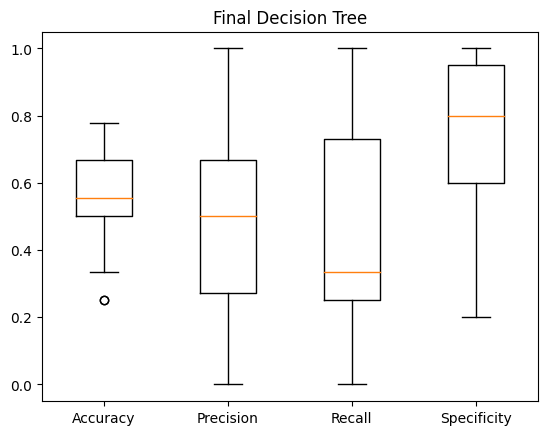

In [130]:
plt.boxplot([accs, pres, recs, specs])
plt.xticks([1, 2, 3, 4], ['Accuracy', 'Precision', 'Recall', 'Specificity'])
plt.title('Final Decision Tree')
plt.show()

<div class='alert alert-block alert-danger'>
We can compare with previous models, the final model performs slightly better as accuracy shrinks. Meanwhile, the model <b>predicts negative outcomes better</b>, which is "people who do not have dementia" than positve outcomes, "people probably have dementia".
</div>